In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random

import torch.optim as optim
from torch.optim import lr_scheduler

from collections import OrderedDict
from tqdm import tqdm

from torchsummary import summary

from albumentations.augmentations import transforms, Normalize
from albumentations import Flip, RandomRotate90, Resize
from albumentations.core.composition import Compose, OneOf

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
SIZE = 128
batch_size = 1
base_dir = '' # Local
num_workers = 1
lr = 0.0001
min_lr = 0.00001
epochs = 50
early_stopping = 5
# base_dir = '/content/' # Colab
root_path = os.path.join(base_dir, 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/')
semantic = False
device = torch.device('cuda:0')

classes = ['normal', 'benign', 'malignant']
labels = []
num_classes = 3 if semantic else 1

if semantic:
    labels = classes
else:
    labels = ['cancer']

In [3]:
all_images = glob.glob(os.path.join(root_path, "**/*).png"), recursive=True)

image_paths = []
mask_paths = []

for path in all_images:
    if 'normal' in path:
        continue

    image_paths.append(path)
    cur_mask_path = []
    mask_path_1 = path.replace('.png', '_mask.png')
    mask_path_2 = path.replace('.png', '_mask_1.png')
    cur_mask_path.append(mask_path_1)
    if os.path.exists(mask_path_2):
        cur_mask_path.append(mask_path_2)
    mask_paths.append(cur_mask_path)

image_paths = np.array(image_paths)
mask_paths = np.array(mask_paths, dtype=object)

In [4]:
from data import *
from metrics import *
from utils import *
from models import *

dataset = BUSIDataset(image_paths=image_paths, mask_paths=mask_paths)

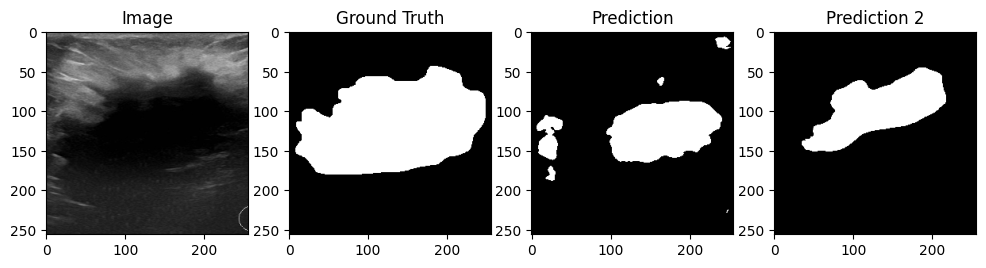

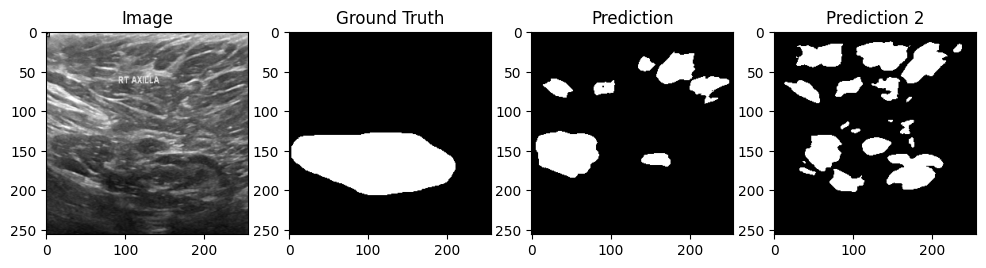

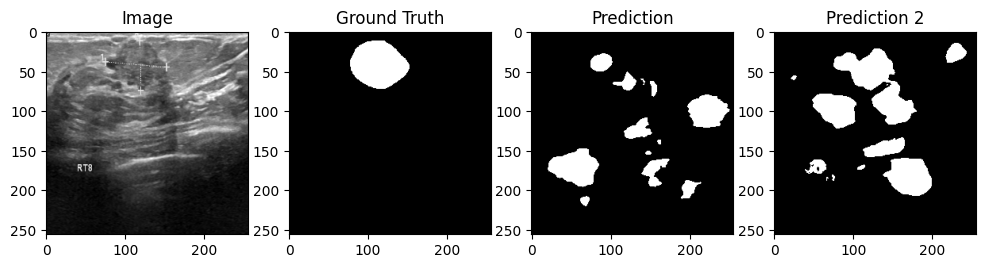

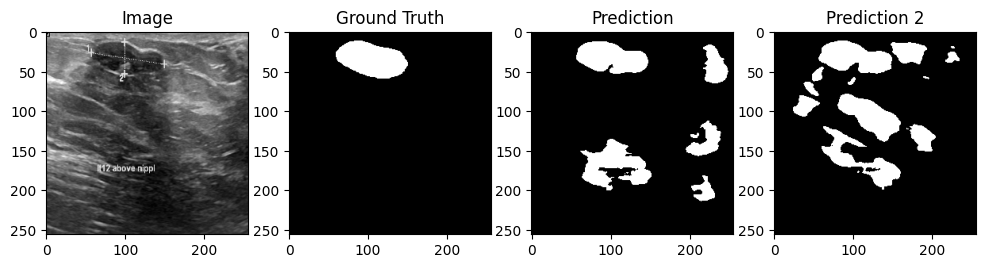

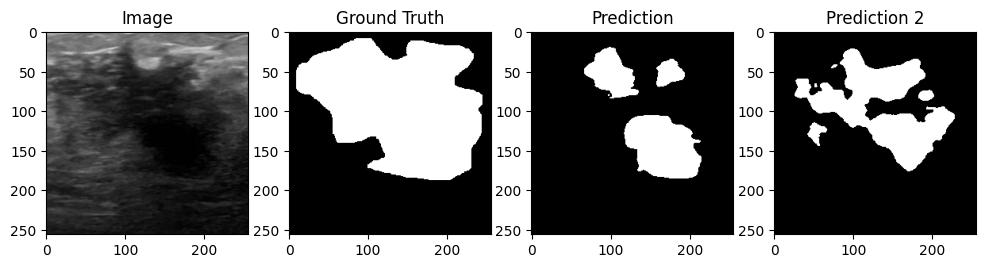

In [13]:
import models

def compare_models(model1_name, model2_name, count):
    model1 = models.__dict__[model1_name](n_channels=1, n_classes=1).cuda()
    model2 = models.__dict__[model2_name](n_channels=1, n_classes=1).cuda()

    model1.load_state_dict(torch.load(f'models/{model1_name}/model.pth'))
    model2.load_state_dict(torch.load(f'models/{model2_name}/model.pth'))

    for _ in range(count):

        idx = random.randint(0, len(image_paths) - 1)

        image, mask = load_tensor(image_paths[idx], mask_paths[idx])
        mask = mask.unsqueeze(0)
        image = image.unsqueeze(0)
        model1_prediction = model1(image)
        model2_prediction = model2(image)
        compare_prediction(image, mask, model1_prediction, model2_prediction)

compare_models('UNet', 'Wavelet_UNet_All', 5)

In [6]:
# print(sum(p.numel() for p in unet_model.parameters() if p.requires_grad))
# print(sum(p.numel() for p in mrunet_model.parameters() if p.requires_grad))
# print(sum(p.numel() for p in mrunet2_model.parameters() if p.requires_grad))

wunet = Wavelet_UNet(n_channels=1, n_classes=1)
print(sum(p.numel() for p in wunet.parameters() if p.requires_grad))

17261825


In [7]:
import pandas as pd

def print_status(model_name):
    path = f"models/{model_name}/log.csv"
    log = pd.read_csv(path)
    best_score = log['val_dice'].max()
    # print total row count of the log    
    print(f"{model_name} - Best Val Dice Score: {best_score}, Total Epochs: {len(log)}")

In [8]:
print_status('UNet')
print_status('MR_UNet')
print_status('MR_UNet2')
print_status('MR_UNet_HH')
print_status('MR_UNet_All')
print_status('Wavelet_UNet')
print_status('Wavelet_UNet_All')

UNet - Best Val Dice Score: 0.7419745604956489, Total Epochs: 50
MR_UNet - Best Val Dice Score: 0.7623440537104597, Total Epochs: 50
MR_UNet2 - Best Val Dice Score: 0.8107432608493343, Total Epochs: 100
MR_UNet_HH - Best Val Dice Score: 0.7170866366114018, Total Epochs: 61
MR_UNet_All - Best Val Dice Score: 0.8095692252149866, Total Epochs: 100
Wavelet_UNet - Best Val Dice Score: 0.7257829157980797, Total Epochs: 50
Wavelet_UNet_All - Best Val Dice Score: 0.570079489250504, Total Epochs: 39


(1, 3, 256, 256)
Stacked shape: torch.Size([3, 4, 128, 128])
torch.Size([3, 16, 128, 128])
tensor([[0.0000, 1.0032, 0.0000,  ..., 0.0000, 0.0777, 0.0000],
        [0.1559, 1.2931, 0.0000,  ..., 0.2317, 0.0000, 0.2950],
        [0.0000, 0.0000, 0.1942,  ..., 0.0000, 0.0000, 0.7121],
        ...,
        [0.7696, 0.0000, 0.0000,  ..., 0.0000, 0.5957, 0.9945],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 3.6220],
        [4.5685, 0.0000, 0.0000,  ..., 0.0000, 0.7183, 0.0000]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.4441, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.2565, device='cuda:0', grad_fn=<MeanBackward0>)


/home/cse/miniconda3/envs/busi/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


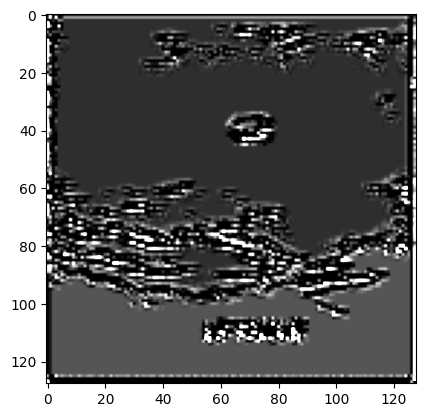

tensor([[2.5722, 0.7730, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.9537, 1.0842, 0.0000],
        [4.1676, 0.0000, 0.0000,  ..., 0.4951, 1.7534, 0.0000],
        ...,
        [0.0000, 2.4509, 1.5215,  ..., 2.6973, 0.0000, 1.1088],
        [1.5006, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [6.9054, 4.1502, 2.5390,  ..., 4.3885, 4.2637, 0.0000]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.9054, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.3103, device='cuda:0', grad_fn=<MeanBackward0>)


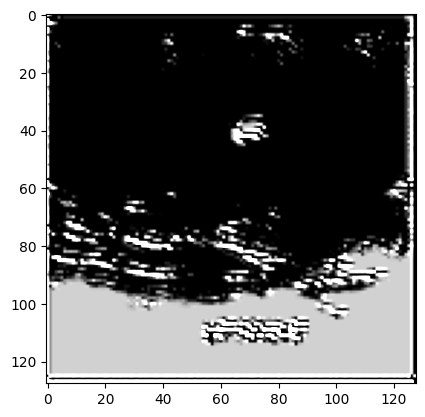

tensor([[0.0000, 1.3616, 1.7021,  ..., 0.0000, 0.6563, 0.2492],
        [1.3244, 0.0000, 0.0000,  ..., 0.0000, 0.2137, 1.3205],
        [1.5093, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5974],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.3162, 0.5026, 0.0000,  ..., 1.5098, 1.0053, 1.0888],
        [1.5759, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(2.0254, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5212, device='cuda:0', grad_fn=<MeanBackward0>)


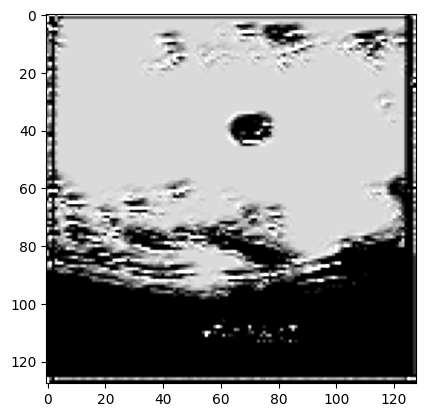

tensor([[0.0000, 2.4348, 0.9641,  ..., 0.0000, 0.1352, 0.0000],
        [0.0000, 0.9842, 2.5887,  ..., 0.7906, 1.4578, 0.2530],
        [3.1673, 5.4690, 2.0510,  ..., 0.7394, 0.6364, 0.0000],
        ...,
        [0.0000, 2.7268, 3.0115,  ..., 2.2281, 0.1255, 1.8589],
        [3.5548, 1.1176, 3.0697,  ..., 0.0000, 5.0686, 0.0000],
        [0.0000, 0.0000, 6.8692,  ..., 3.9410, 6.1043, 2.4939]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(10.1497, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.3696, device='cuda:0', grad_fn=<MeanBackward0>)


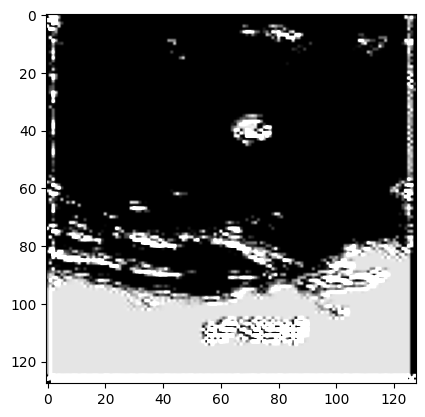

tensor([[1.2474, 0.0000, 0.0000,  ..., 1.4232, 2.0010, 0.8210],
        [2.8086, 2.6614, 3.6319,  ..., 2.0578, 1.9151, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.5158, 1.2762, 0.0000],
        ...,
        [2.0058, 1.4631, 0.0000,  ..., 2.3219, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3057,  ..., 1.0829, 0.0000, 0.4598],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(10.4295, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.2692, device='cuda:0', grad_fn=<MeanBackward0>)


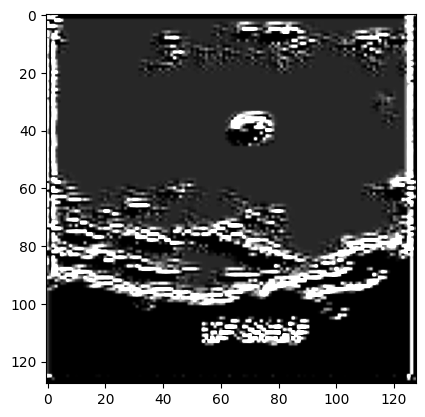

tensor([[0.1627, 4.1786, 0.0000,  ..., 0.0000, 0.5386, 1.0011],
        [3.2703, 1.2506, 0.0000,  ..., 0.0000, 0.0000, 1.0237],
        [4.0967, 0.0000, 1.6868,  ..., 0.2099, 0.0000, 0.3864],
        ...,
        [1.7541, 0.0671, 0.0000,  ..., 0.0000, 2.9218, 0.9164],
        [5.7039, 0.0000, 1.0289,  ..., 0.0000, 6.6137, 0.0000],
        [0.6335, 0.0000, 0.0000,  ..., 0.0000, 1.1960, 0.0000]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.7759, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4900, device='cuda:0', grad_fn=<MeanBackward0>)


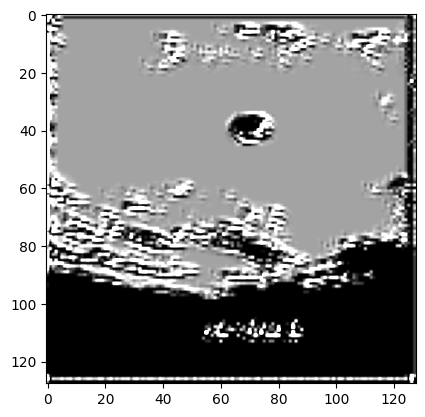

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.3875, 0.0000, 0.3745],
        [0.0000, 0.0000, 9.6470,  ..., 0.0000, 0.0000, 1.0014],
        ...,
        [0.5017, 0.0000, 0.0000,  ..., 0.0000, 0.4635, 0.0000],
        [6.1273, 1.4224, 6.2628,  ..., 5.1160, 8.1164, 0.0000],
        [0.0000, 0.0000, 7.3824,  ..., 2.1004, 3.4569, 8.4249]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(9.6470, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.2711, device='cuda:0', grad_fn=<MeanBackward0>)


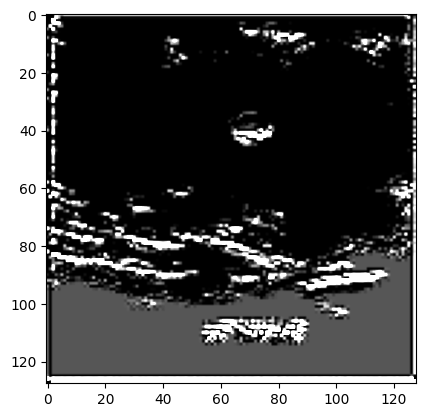

tensor([[0.0000, 3.2256, 0.0000,  ..., 0.7079, 0.0000, 0.3124],
        [0.0000, 0.0000, 2.5803,  ..., 0.6653, 0.1322, 0.8921],
        [4.6217, 0.7834, 0.0000,  ..., 0.0000, 0.0000, 0.7136],
        ...,
        [0.6349, 0.0000, 0.0000,  ..., 0.0000, 1.6540, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1690, 1.9118, 0.0000,  ..., 0.0000, 1.0064, 2.0978]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.7833, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4992, device='cuda:0', grad_fn=<MeanBackward0>)


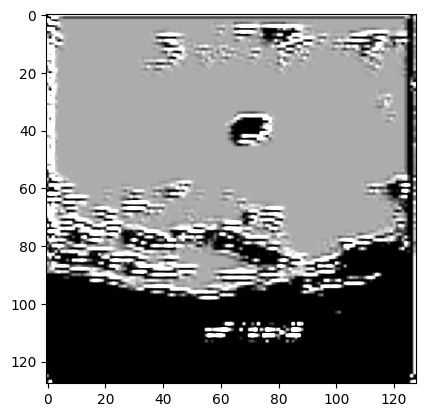

tensor([[1.9874, 0.6737, 0.0000,  ..., 0.0000, 0.2865, 0.0949],
        [0.0000, 1.7322, 0.0000,  ..., 0.3054, 0.1122, 0.0000],
        [2.0505, 0.0000, 0.0000,  ..., 0.3689, 0.0000, 0.0000],
        ...,
        [0.0000, 0.6939, 0.0000,  ..., 0.0000, 0.0000, 2.9973],
        [0.0000, 0.0000, 0.3781,  ..., 0.0000, 0.7288, 0.0000],
        [0.0000, 0.0000, 1.2500,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(5.0895, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5088, device='cuda:0', grad_fn=<MeanBackward0>)


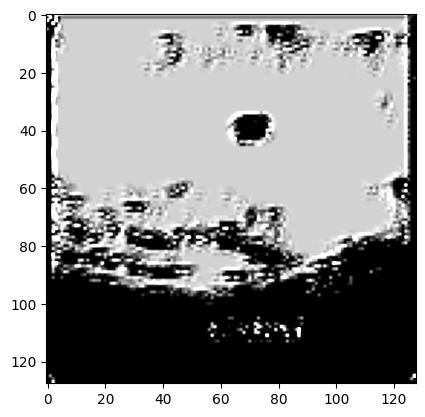

tensor([[0.0000e+00, 1.5878e-01, 0.0000e+00,  ..., 1.6026e+00, 4.0815e-03,
         2.1846e-01],
        [0.0000e+00, 2.6374e-01, 0.0000e+00,  ..., 7.3886e-01, 1.4980e-01,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 4.6788e+00,  ..., 6.1644e-01, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.4773e-01,
         1.6065e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 4.2477e+00,  ..., 4.2232e+00, 2.3055e+00,
         1.6095e+00]], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(9.8392, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.3278, device='cuda:0', grad_fn=<MeanBackward0>)


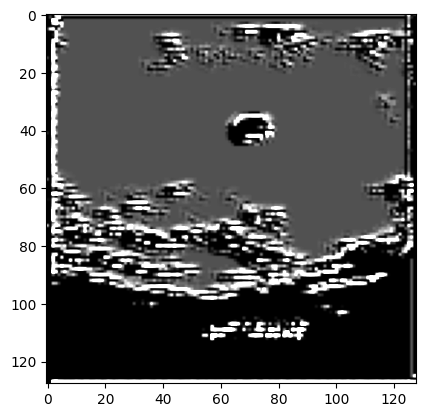

tensor([[1.0951, 2.0694, 1.6414,  ..., 0.6197, 0.5913, 0.0000],
        [4.0804, 0.0000, 3.3059,  ..., 0.5960, 0.7704, 0.0000],
        [0.0000, 4.6661, 3.7423,  ..., 0.9297, 0.9271, 0.0000],
        ...,
        [2.0982, 2.2749, 5.3953,  ..., 3.6245, 5.8829, 0.3433],
        [1.2208, 4.4110, 5.4484,  ..., 5.8376, 3.1206, 2.8322],
        [0.0000, 5.2163, 6.1082,  ..., 7.3633, 1.1322, 6.5514]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.3633, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.2680, device='cuda:0', grad_fn=<MeanBackward0>)


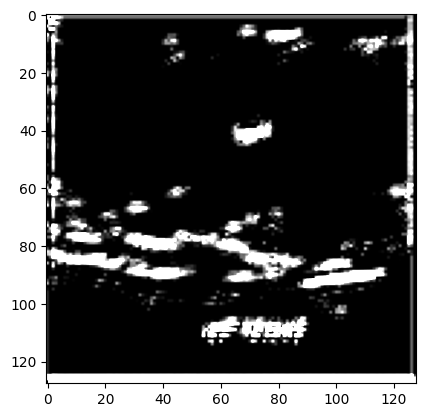

tensor([[0.6950, 0.0000, 0.7602,  ..., 0.4673, 0.2210, 0.6225],
        [0.0000, 0.0000, 0.5879,  ..., 0.0000, 0.0000, 1.9820],
        [0.9896, 0.8410, 0.0000,  ..., 0.0000, 0.2308, 1.8654],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.0303],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1220],
        [2.9631, 3.2187, 4.6679,  ..., 2.5916, 5.8177, 1.7232]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.7544, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.3963, device='cuda:0', grad_fn=<MeanBackward0>)


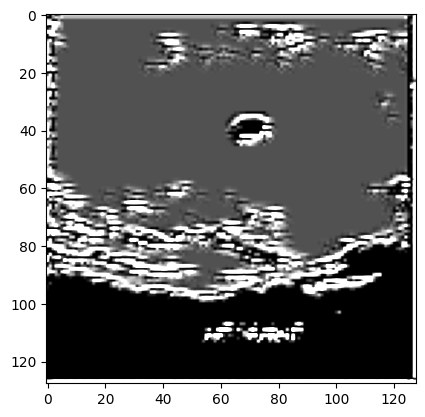

tensor([[0.0000, 0.0000, 1.4948,  ..., 0.3032, 0.3078, 0.1627],
        [0.1765, 0.0000, 1.6702,  ..., 0.0000, 0.8348, 0.9113],
        [0.8213, 4.9378, 2.8981,  ..., 0.0000, 0.0000, 1.1721],
        ...,
        [0.1117, 0.1048, 0.0000,  ..., 0.9145, 0.1282, 0.0000],
        [1.1102, 5.7245, 6.2311,  ..., 5.3644, 3.9006, 3.9229],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.3865]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(6.5413, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.3530, device='cuda:0', grad_fn=<MeanBackward0>)


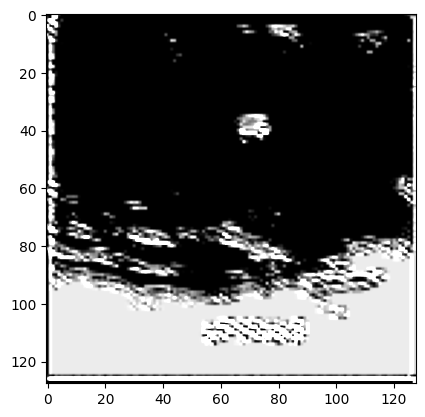

tensor([[0.1960, 0.0000, 0.0617,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.6391, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0858, 0.0000, 2.8234],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1123],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.9863]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(4.2266, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.3141, device='cuda:0', grad_fn=<MeanBackward0>)


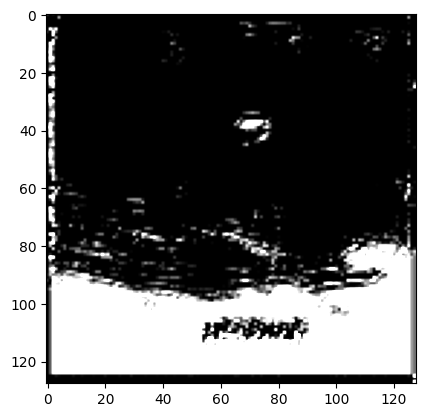

tensor([[2.3978, 0.4192, 0.0000,  ..., 0.0000, 0.7068, 0.0000],
        [0.0000, 2.8198, 5.6959,  ..., 0.0000, 0.2062, 0.4898],
        [0.4141, 0.0000, 2.4103,  ..., 0.0000, 0.5807, 0.5404],
        ...,
        [0.2040, 4.7353, 6.0801,  ..., 4.2039, 4.0494, 3.8174],
        [0.0000, 0.0000, 2.7433,  ..., 2.0833, 0.0000, 0.0000],
        [0.0000, 2.9876, 5.5499,  ..., 4.4463, 1.1902, 1.8389]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(7.2535, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.3421, device='cuda:0', grad_fn=<MeanBackward0>)


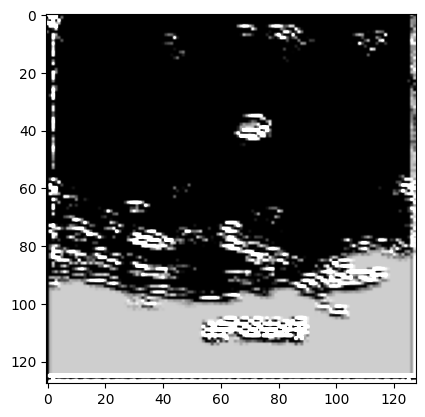

tensor([[0.3905, 0.0000, 0.0000,  ..., 1.8945, 1.4640, 0.2792],
        [0.0000, 0.0000, 0.7858,  ..., 0.6389, 0.0000, 0.3895],
        [0.0000, 0.0000, 2.0000,  ..., 0.7486, 0.8166, 0.5859],
        ...,
        [0.7637, 0.0000, 0.0000,  ..., 1.1978, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(2.7623, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4364, device='cuda:0', grad_fn=<MeanBackward0>)


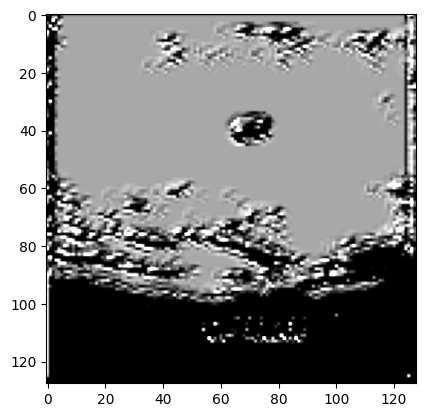

In [11]:
from transform2d import DWTForward, DWTInverse
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import numpy as np

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class WaveletDownsamplingAll(nn.Module):
    def __init__(self, wavelet='db1', level=1):
        super(WaveletDownsamplingAll, self).__init__()
        self.wavelet = wavelet
        self.level = level
        self.dwt_forward = DWTForward(wave=self.wavelet, J=self.level)
        self.conv = DoubleConv(4, 1)

    def forward(self, x):
        coeffs = self.dwt_forward(x)
        # for each channel of x, extract all 4 dwt components ll, hl, lh, hh

        ll = coeffs[0]
        lh = coeffs[1][0][:, :, 0]
        hl = coeffs[1][0][:, :, 1]
        hh = coeffs[1][0][:, :, 2]
        # normalize all 4 channels
        ll = (ll - ll.min()) / (ll.max() - ll.min())
        lh = (lh - lh.min()) / (lh.max() - lh.min())
        hl = (hl - hl.min()) / (hl.max() - hl.min())
        hh = (hh - hh.min()) / (hh.max() - hh.min())

        # stack the channels together
        stacked = torch.stack([ll, lh, hl, hh], dim=2)
        stacked.squeeze_(0)

        # apply convolution on the stacked tensor
        f = self.conv(stacked)

        return f

class Wavelet_Down_All(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, wavelet):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            WaveletDownsamplingAll(wavelet=wavelet, level=1),
            nn.BatchNorm2d(in_channels),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

image1 = '/home/cse/Documents/g1/git-repo/wavelet-ensemble-unet/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (1).png'
image1 = cv2.imread(image1)
image1 = cv2.resize(image1, (256, 256))
image1 = image1[:, :, 0]
image1 = np.expand_dims(image1, 0)

image2 = '/home/cse/Documents/g1/git-repo/wavelet-ensemble-unet/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (2).png'
image2 = cv2.imread(image2)
image2 = cv2.resize(image2, (256, 256))
image2 = image2[:, :, 0]
image2 = np.expand_dims(image2, 0)

image3 = '/home/cse/Documents/g1/git-repo/wavelet-ensemble-unet/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (3).png'
image3 = cv2.imread(image3)
image3 = cv2.resize(image3, (256, 256))
image3 = image3[:, :, 0]
image3 = np.expand_dims(image3, 0)

image = np.concatenate([image1, image2, image3], axis=0)
image = np.expand_dims(image, 0)

image = image / 255.0
print(image.shape)

image = torch.tensor(image).to(device='cuda', dtype=torch.float)
downsampled_image = Wavelet_Down_All(1, 16, wavelet='db1').cuda()(image)
print(downsampled_image.shape)

c = downsampled_image.shape[1]
for i in range(c):
    print(downsampled_image[0,i])
    print(torch.max(downsampled_image[0,i]), torch.min(downsampled_image[0,i]), torch.mean(downsampled_image[0,i]))
    plt.imshow(downsampled_image[0,i].detach().cpu().numpy().squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.show()